# Wav2Vec2 - FakeAVCeleb - Retreival Augmented Framework for Deepfake Audio Detection

## Wav2Vec2 Model for Deepfake Audio Detection

### Summary of Key Processing Steps in Wav2Vec2

1. Directly processes raw audio using convolutional layers in the feature encoder.
2. Utilizes a Transformer to capture temporal relationships across the audio sequence.
3. Fine-tunes easily for classification tasks by adding a lightweight classification head.
4. Pre-trained on vast unlabeled audio data, enabling it to perform well with limited labeled data for classification.

## Training

In [5]:
import logging
from config import Config
from dataset import AudioDataset
import argparse
import os
from pipeline import DeepfakeDetectionPipeline
import torch

# ========================
# Main runner (same behavior; wandb toggle)
# ========================
"""
Run the complete audio deepfake detection pipeline with single-GPU optimizations.
"""
import argparse

# 1. Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)

# 3. Disable problematic torchaudio backends
os.environ["TORCHAUDIO_USE_SOX"] = "0"
os.environ["TORCHAUDIO_USE_BACKEND_DISPATCHER"] = "1"

# 4. Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if device.type == "cuda":
    torch.cuda.set_device(device)

# 5. Create configuration
config = Config()
config.device = device
config.train_data_path = "/content/FakeAVCelebAudio/"
config.test_data_path = "/content/FakeAVCelebAudio/"
config.train_split = 0.8
mode = "train"
audio_path = None
config.feature_extractor_type = "wav2vec2"
pipeline_check = False

if pipeline_check:
  config.data_fraction = 0.01
  config.num_epochs = 2
  # 5a. Wandb toggle
  use_wandb = False  # set False to disable W&B
else:
  config.data_fraction = 1.0
  config.num_epochs = 10
  # 5a. Wandb toggle
  use_wandb = True  # set False to disable W&B


config.use_wandb = use_wandb

# 6. DataLoader settings
config.num_workers = max(1, torch.cuda.device_count() * 2)
config.train_batch_size = getattr(config, "train_batch_size", 256)
config.eval_batch_size = getattr(config, "eval_batch_size", 256)
config.db_batch_size = getattr(config, "db_batch_size", 64)
config.top_k = getattr(config, "top_k", 5)
config.use_batch_norm = False
config.use_layer_norm = True


# 7. Initialize pipeline
pipeline = DeepfakeDetectionPipeline(config)

if mode == "train":
    train_dataset = AudioDataset(config, is_train=True, split_data=True)
    val_dataset   = AudioDataset(config, is_train=False, split_data=True)
    pipeline.print_split_stats(train_dataset, "Train")
    pipeline.print_split_stats(val_dataset,   "Val")
    pipeline.train(train_dataset, val_dataset)

elif mode == "evaluate":
    config.use_wandb = False
    pipeline.load_models("final_model")
    pipeline.vector_db.load()

    test_dataset = AudioDataset(config, is_train=False, split_data=True)
    if hasattr(pipeline, "evaluate_with_metrics"):
        metrics = pipeline.evaluate_with_metrics(test_dataset)
        print("Evaluation metrics:")
        for key, value in metrics.items():
            print(f"{key}: {value}")
    else:
        loss, acc = pipeline.evaluate(test_dataset)
        print(f"Eval Loss: {loss:.4f}, Eval Acc: {acc:.4f}")

elif mode == "predict":
    if not audio_path:
        raise ValueError("Audio path must be provided for predict mode")
    pipeline.load_models("best_model")
    pipeline.vector_db.load()
    result = pipeline.predict(audio_path)
    logging.info(f"Prediction  : {result['prediction']}")
    logging.info(f"Probability(bona-fide) : {result['probability_bonafide']:.4f}")
    logging.info(f"Retrieved   : {result['retrieved_labels']}")

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Feature dimension set to: 768
Train set → total: 17252, bonafide: 9085 (52.66%), spoof: 8167 (47.34%)
Val set → total: 4314, bonafide: 2272 (52.67%), spoof: 2042 (47.33%)


Vector DB Build: 100%|██████████| 270/270 [07:32<00:00,  1.68s/it]
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: avinash-saxena (avinash-saxena-san-jose-state-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Evaluating: 100%|██████████| 17/17 [01:50<00:00,  6.50s/it]


Epoch 1: Train Loss: 0.6734, Train Acc: 0.5279, Val Loss: 0.6318, Val Acc:0.5751 | AUC: 0.7430, EER: 32.26% (thr=-0.1161), Macro EER: 28.04%, min t-DCF: nan


Evaluating: 100%|██████████| 17/17 [01:49<00:00,  6.46s/it]


Epoch 2: Train Loss: 0.5585, Train Acc: 0.6904, Val Loss: 0.4489, Val Acc:0.7837 | AUC: 0.8690, EER: 20.93% (thr=-0.4155), Macro EER: 17.01%, min t-DCF: nan


Evaluating: 100%|██████████| 17/17 [01:50<00:00,  6.47s/it]


Epoch 3: Train Loss: 0.4241, Train Acc: 0.8062, Val Loss: 0.6739, Val Acc:0.5355 | AUC: 0.8578, EER: 21.42% (thr=0.8779), Macro EER: 18.07%, min t-DCF: nan


Evaluating: 100%|██████████| 17/17 [01:49<00:00,  6.47s/it]


Epoch 4: Train Loss: 0.4343, Train Acc: 0.7968, Val Loss: 0.2630, Val Acc:0.9026 | AUC: 0.9676, EER: 6.02% (thr=1.9326), Macro EER: 5.06%, min t-DCF: nan


Evaluating: 100%|██████████| 17/17 [01:50<00:00,  6.47s/it]


Epoch 5: Train Loss: 0.3545, Train Acc: 0.8660, Val Loss: 0.5046, Val Acc:0.7049 | AUC: 0.9782, EER: 3.71% (thr=1.6943), Macro EER: 3.32%, min t-DCF: nan


Epoch 6/10:   1%|▏         | 1/68 [00:06<07:35,  6.79s/it]wandb: WARNING Tried to log to step 340 that is less than the current step 341. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 340 that is less than the current step 342. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
Evaluating: 100%|██████████| 17/17 [01:50<00:00,  6.48s/it]


Epoch 6: Train Loss: 0.3507, Train Acc: 0.8608, Val Loss: 0.2592, Val Acc:0.8987 | AUC: 0.9736, EER: 4.68% (thr=2.3535), Macro EER: 3.88%, min t-DCF: nan


Epoch 7/10:   3%|▎         | 2/68 [00:13<07:23,  6.72s/it]wandb: WARNING Tried to log to step 408 that is less than the current step 410. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 409 that is less than the current step 410. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
Evaluating: 100%|██████████| 17/17 [01:49<00:00,  6.47s/it]


Epoch 7: Train Loss: 0.2079, Train Acc: 0.9310, Val Loss: 0.9852, Val Acc:0.6340 | AUC: 0.9035, EER: 18.07% (thr=-3.1426), Macro EER: 12.70%, min t-DCF: nan


Evaluating: 100%|██████████| 17/17 [01:50<00:00,  6.48s/it]


Epoch 8: Train Loss: 0.1925, Train Acc: 0.9396, Val Loss: 0.1667, Val Acc:0.9655 | AUC: 0.9751, EER: 3.55% (thr=-1.3389), Macro EER: 3.80%, min t-DCF: nan


wandb: WARNING Tried to log to step 544 that is less than the current step 545. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
Evaluating: 100%|██████████| 17/17 [01:50<00:00,  6.48s/it]


Epoch 9: Train Loss: 0.2775, Train Acc: 0.9024, Val Loss: 0.4229, Val Acc:0.8449 | AUC: 0.9820, EER: 3.66% (thr=2.9238), Macro EER: 2.21%, min t-DCF: nan


Epoch 10/10:   1%|▏         | 1/68 [00:06<07:40,  6.88s/it]wandb: WARNING Tried to log to step 612 that is less than the current step 613. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 612 that is less than the current step 614. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
Evaluating: 100%|██████████| 17/17 [01:50<00:00,  6.51s/it]


Epoch 10: Train Loss: 0.2375, Train Acc: 0.9219, Val Loss: 0.6646, Val Acc:0.7701 | AUC: 0.9832, EER: 4.76% (thr=-3.4414), Macro EER: 2.84%, min t-DCF: nan


curves/auc,▁▅▄███▆███
grad_norm/detection,▁▂▁▁▂▂▃▁▂▃█▄▄▂▁▂▅▅▃▂▆▄▁▂▁▁▁▂▂▁▁▁▁▁▁▄▃▃▃▁
grad_norm/fuse,▂▁▁▁▁▂▁▁▁▂█▄▁▁▃▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▁
grad_norm/projection,▁▁▁▁▂▂▂▁▁▃▂▁▂▂▂▂▄▁▁▂▂▁▃▂▁█▃▅▄▅▆▂▁▂▁▂▆▁▂▅
lr/detection,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr/fuse,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr/projection,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/batch_loss,▆▆▆▆▆▆▆▅▅▅▄▄▃▆▂▂▂▂▁▅▂▂▂▅▁▂▂▂▁▁▄▂▂▁▃▃▃▁▁█
train/nnz_neighbor_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
curves/auc,0.98321
grad_norm/detection,0.23469


## Loss and Accuracy Curves

In [6]:
pipeline.plot_training_curves()

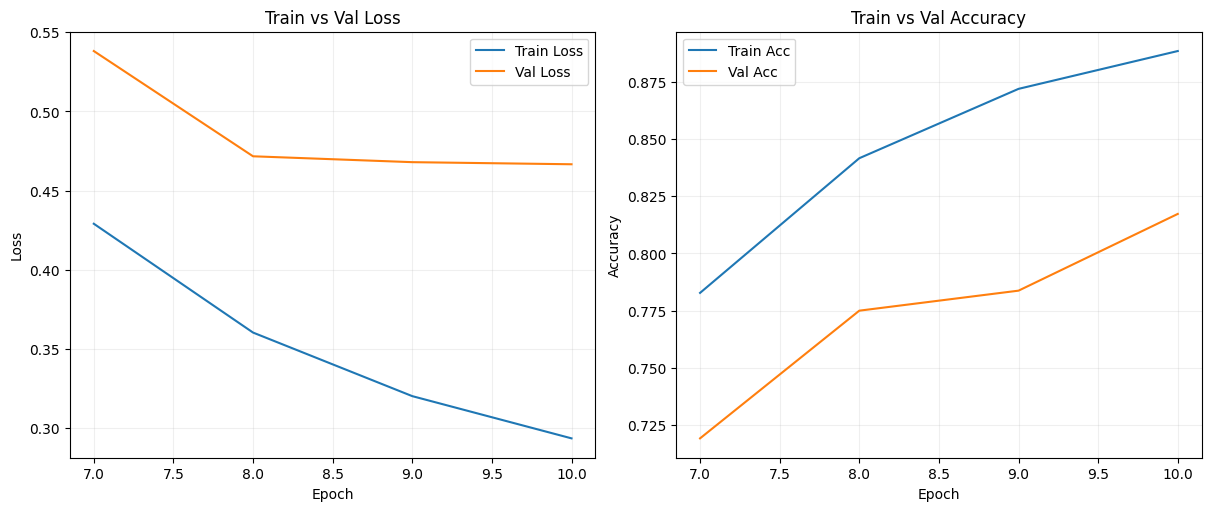

In [7]:
pipeline.show_curves_inline(smooth=7)

## Sample Predictions

### Spoof Prediction

In [14]:
import pandas as pd
file_name = "FakeAVCeleb_FakeVideo-FakeAudio_Asian_South_women_id07689__00028_id06254_wavtolip.wav"
audio_path = "/content/FakeAVCelebAudio/"+file_name

df = pd.read_csv("/content/FakeAVCelebAudio/meta.csv")
expected = df[df["file"]==file_name]


# 12. Single-file prediction on GPU
result = pipeline.predict(audio_path)

filtered_df = df[df["file"].isin(result['retrieved_files'])]


print(f"Prediction  : {result['prediction']}, Expected: {expected['label'].values[0]}, Speaker: {expected['speaker'].values[0]}")
print(f"Probability Spoof: {result['probability_spoof']:.4f}")
print("Similar Audio Files retrieved")
print(filtered_df)

Prediction  : spoof, Expected: spoof, Speaker: id07689
Probability Spoof: 0.9042
Similar Audio Files retrieved
                                                    file  speaker  label
4180   FakeAVCeleb_FakeVideo-FakeAudio_Asian_South_wo...  id00488  spoof
4233   FakeAVCeleb_FakeVideo-FakeAudio_Asian_South_wo...  id03897  spoof
21098  FakeAVCeleb_FakeVideo-FakeAudio_Asian_South_wo...  id00043  spoof
21460  FakeAVCeleb_FakeVideo-FakeAudio_Asian_South_wo...  id06439  spoof
21553  FakeAVCeleb_FakeVideo-FakeAudio_Asian_South_wo...  id07686  spoof


### Bonafide Prediction

In [11]:
file_name = "FakeAVCeleb_RealVideo-RealAudio_African_men_id00391__00052.wav"
audio_path = "/content/FakeAVCelebAudio/"+file_name

df = pd.read_csv("/content/FakeAVCelebAudio/meta.csv")
expected = df[df["file"]==file_name]


# 12. Single-file prediction on GPU
result = pipeline.predict(audio_path)

filtered_df = df[df["file"].isin(result['retrieved_files'])]


print(f"Prediction  : {result['prediction']}, Expected: {expected['label'].values[0]}, Speaker: {expected['speaker'].values[0]}")
print(f"Probability Spoof: {result['probability_spoof']:.4f}")
print("Similar Audio Files retrieved")
print(filtered_df)

Prediction  : bona-fide, Expected: bona-fide, Speaker: id00391
Probability Spoof: 0.0288
Similar Audio Files retrieved
                                                   file  speaker      label
1073  FakeAVCeleb_FakeVideo-RealAudio_African_men_id...  id02296  bona-fide
4488  FakeAVCeleb_FakeVideo-RealAudio_African_men_id...  id00391  bona-fide
4489  FakeAVCeleb_FakeVideo-RealAudio_African_men_id...  id00391  bona-fide
4490  FakeAVCeleb_FakeVideo-RealAudio_African_men_id...  id00391  bona-fide
4494  FakeAVCeleb_FakeVideo-RealAudio_African_men_id...  id00391  bona-fide
